# Optimization for Machine Learning from scratch | Boston Housing Dataset

In this notebook, we are implementing from scratch a total of 11 versions of Gradient Descent algorithm, from the following paper [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747.pdf) by Sebastian Ruder (2017).

In this project, we'll start gradually implementing Gradient Descent algorithms from the simplest, to the most advanced versions by applying it to [The Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), in order to predict House prices from various independant features. Therefore, we are solving a linear regression problem, and we are going to define some notations to adopt all along the problem.

First, we are going to use the **Mean Squared Error (MSE loss)** for this problem, and we are defining it by the following expression:

$$
L(W) = \frac{1}{N} \sum_{i=1}^{N}\left(Y_{i}-\hat{Y}_{i}\right)^{2} = \frac{1}{N}  \|X W-Y \|^{2}.
$$

$ \underline{where:} $

- **F**: The number of independant features in the dataset.


- **N**: The number of samples in the dataset.


- $ W=\left[b, w_{1}, \ldots, \omega_{F}\right]^{T} $: The weight vector of size $ \mathbb{R}^{F+1, 1} $, where b is the bias and $ w_{1}, \ldots, \omega_{F} $ are the weights.


- $ Y = \left[Y_{1}, Y_{2}, \ldots, Y_{N}\right]^{T} $: The label vector of size $ \mathbb{R}^{N, 1} $, where every $ Y_{i} $ is a house price.


- $ X = \left[\vec{X}_{1}, \vec{X}_{2}, \ldots, \vec{X}_{N}\right]^{T} = 
\left[\begin{array}{ccccc}
1 & X_{11} & X_{12} & \ldots & X_{1 F} \\
1 & X_{21} & X_{22} & \ldots & X_{2 F} \\
\vdots & \vdots & \vdots & & \vdots \\
\vdots & \vdots & \vdots & & \vdots \\
1 & X_{N 1} & X_{N 2} & \ldots & X_{N F}
\end{array}\right]
$: The feature matrix of size $ \mathbb{R}^{N, F+1} $, and where $ \vec{X}_{i} = \left[1, X_{i 1}, \ldots, X_{i F}\right]$ .


- $ \hat{Y}=X W=\left[\hat{Y}_{1}, \hat{Y}_{2}, \ldots, \hat{Y}_{N}\right]^{\top} $: The price estimation vector of size $ \mathbb{R}^{N, 1} $, where every $ \hat{Y}_{i} $ is a house price estimation.



In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from numpy.linalg import inv, norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from IPython.display import Image
sns.set(rc={'figure.figsize':(17,10)})

## 1)- Data pre-processing

As it was mentionned before, we are using [The Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), that was derived from information collected by the U.S. Census Service concerning housing in the area of Boston Mass. It contains a total of **506 samples and 13 features**.

Some details about the **13 features** in the dataset can be summerized below:

**1.** CRIM - per capita crime rate by town.

**2.** ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

**3.** INDUS - proportion of non-retail business acres per town.

**4.** CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise).

**5.** NOX - nitric oxides concentration (parts per 10 million).

**6.** RM - average number of rooms per dwelling.

**7.** AGE - proportion of owner-occupied units built prior to 1940.

**8.** DIS - weighted distances to five Boston employment centres.

**9.** RAD - index of accessibility to radial highways.

**10.** TAX - full-value property-tax rate per 10,000.

**11.** PTRATIO - pupil-teacher ratio by town.

**12.** B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

**13.** LSTAT - % lower status of the population.


In [2]:
# Loading the dataset with Scikit-learn
boston = load_boston()
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
df_boston['MEDV'] =  boston.target

df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


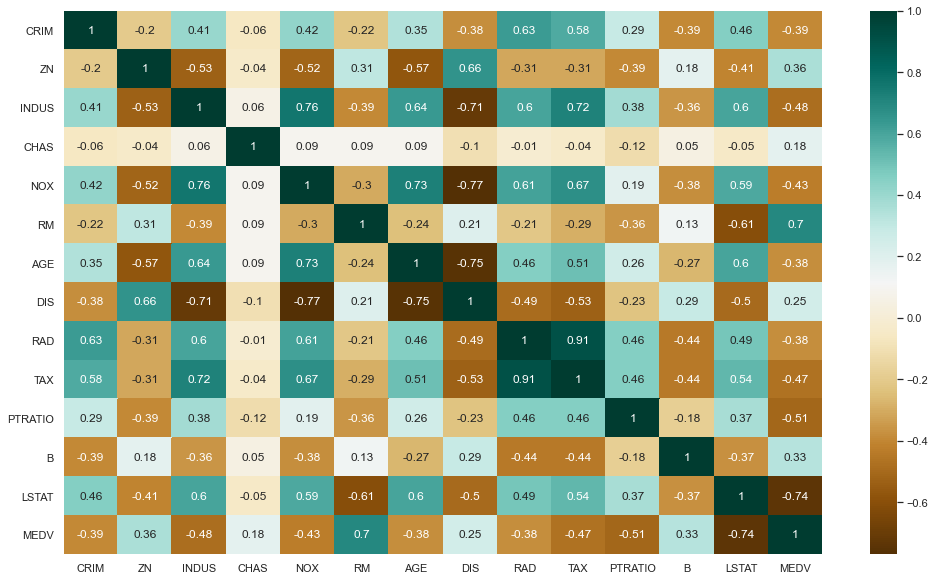

In [3]:
# Plot the correlation matrix between features
corr_mat = df_boston.corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap="BrBG")
plt.show()

In [4]:
# Keep only features that are highly correlated with the target
corr_target = abs(corr_mat["MEDV"])
feats_to_keep = corr_target[corr_target > 0.5]
feats_to_keep


RM         0.70
PTRATIO    0.51
LSTAT      0.74
MEDV       1.00
Name: MEDV, dtype: float64

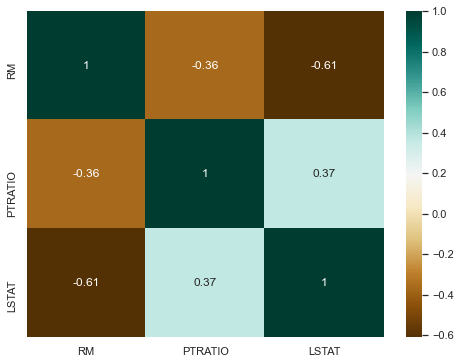

In [5]:
# Making sure that the features are independant to satisfy the linear regression assumptions
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(data=df_boston[["RM", "PTRATIO", "LSTAT"]].corr().round(2), annot=True, cmap="BrBG")
plt.show()

In [6]:
# Define the training data & labels
X = df_boston[['PTRATIO', 'LSTAT']]
Y = df_boston.MEDV

# Normalize the dataset
X = (X - X.mean(axis=0))/ X.std(axis=0)
X, Y = X.to_numpy(), Y.to_numpy().reshape(-1, 1)
N, F = X.shape

# Add a vector of ones in the first column of X for bias estimation
X = np.hstack((np.ones((N, 1)), X))

# Split the dataset into train/test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print("Train data shape: {}".format(x_train.shape))
print("Test data shape: {}".format(x_test.shape))

Train data shape: (455, 3)
Test data shape: (51, 3)


## 2)- The classic LSE solution for the optimization problem

The loss expression we are going to use from now on is: $$ L(W) = \frac{1}{N} \|X W-Y \|^{2} $$

In order to solve this optimization problem, we are going to proceed by calculating the gradient of the loss with respect to the weight vector **W**, and then solve the equation $ \begin{array}{l} \nabla_{W} L=0 \\ \end{array} $, to find the optimal weight vector $ W^{*}$, for which the minimum loss value is reached.


$$
\begin{aligned}
L(W) &=\frac{1}{N} \|X W-Y\|^{2} \\
&=\frac{1}{N} (X W-Y)^{T}(X W-Y) \\
&=\frac{1}{N} \left(W^{T} X^{T}-Y^{T}\right)(X W-Y) \\
&=\frac{1}{N} \left(W^{T} X^{T} X W-W^{T} X^{T} Y-Y^{T} X W+Y^{T} Y \right)\\
\end{aligned}
$$

So, by applying some differential calculus we have:

$$
\left\{\begin{array}{l}
\frac{\partial W^{T} X^{T} X W}{\partial W}=2 W^{T} X^{T} X \\
\frac{\partial W^{T} X^{T} Y}{\partial W}=Y^{T} X \\
\frac{\partial Y^{T} X W}{\partial W}=Y^{T} X
\end{array}\right.
$$

To sum up, the expression of the gradient will be: 

$$
\nabla_{W}L=\frac{2}{N} \left(W^{T} X^{T} X-2 Y^{T} X\right)
$$

Therefore, the optimal weight vector $ W^{*} $ expression is:

$$
\nabla_{W}L=0 \quad \Leftrightarrow \quad \boxed{W^{*}=\left(X^{T} X\right)^{-1} X^{T} Y}
$$

        
        
        



In [174]:
# Use the training samples to find the optimal weight vector
W_star = np.matmul(inv(np.matmul(x_train.T,x_train)), np.matmul(x_train.T, y_train))

# Test on new data samples with RMSE loss
n_test = x_test.shape[0]
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_star) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

The test RMSE loss is: 8.67807908466714


The reason why people use **Gradient Descent Algorithm** instead of the LSE solution, is the huge complexity of this solution that can grow dramatically, as the number of samples **N**, and the number of features **F** grow.

Let's compute how big is this complexity, by analyzing how many operations we are performing to find the solution, and the complexity of each operation. First, let's remind the expression we are analyzing:

$$ \boxed{W^{*}=\left(X^{T} X\right)^{-1} X^{T} Y} $$

In this expression, we are performing the following operations:

**1.** $ X^{T} $ the transpose of a matrix is performed two times so the complexity is $ \Theta(2NF) $.

**2.** $ X^{T} X $ is a matrix multiplication where $ X \in \mathbb{R}^{N,F+1} $, so the complexity is $ \Theta(NF^2) $.

**3.** $ \left(X^{T} X\right)^{-1} $ is the inverse of a matrix of size $ \mathbb{R}^{F+1,F+1} $, and by using **Gauss-Jordan method** to find the inverse, we have a complexity of $ \Theta(F^3) $.

**4.** $ X^{T} Y $ is a matrix multiplication where $ X \in \mathbb{R}^{N,F+1} $, and $ Y \in \mathbb{R}^{N,1} $, so the complexity is $ \Theta(NF) $.

**5.** The matrix multiplication between $ \left(X^{T} X\right)^{-1} $ of size $ \mathbb{R}^{F+1,F+1} $, and $ X^{T} Y $ of size $ \mathbb{R}^{F+1,1} $ has a complexity of $ \Theta(F^2) $.




By suming all these complexities, we'll have:

$$
\begin{aligned}
Complexity &=\Theta(2NF + NF^2 + F^3 + NF + F^2) \\
&=\Theta(F^3 + F^2 + NF^2 + 3NF) \\
\end{aligned}
$$

And we know that:

$$
\left\{\begin{array}{l}
N F \leqslant N F^{2} \\
F^{2} \leqslant F^{3}
\end{array}\right.
$$

So, we'll have:

$$
\boxed{Complexity = \Theta(F^2(N+F))}
$$

We can see that the complexity can easily grow with the number of samples $ N $, and the number of features $ F $, and if we have $ F = N $, the complexity becomes $ \Theta(F^3) $. Now let's see how can we solve this optimization problem using other **Gradient Descent algorithms**.

## 3)- Vanilla gradient descent (aka Batch gradient descent)

**Gradient Descent** is a famous algorithm used to solve optimization problems, by minimizing a loss function $ L(W) $, that depends on various parameters $ W \in \mathbb{R}^{F+1,1} $. The algorithm starts by intializing random weights $ W_{start} $, and updating the weight vector in the opposite direction of the gradient $ \nabla_{W} L $, with a certain step called **the learning rate** $ \alpha $ (controls also the speed of convergence). This step can be summarized by the following formula:

$$
\boxed{W^{(i+1)} = W^{(i)}-\alpha \nabla L_{W}\left(W^{(i)}\right)}
$$

All along the process, we'll use the gradient expression of **the MSE loss** that was mentionned before:

$$
\boxed{\nabla_{W}L(W)=\frac{2}{N} \left(W^{T} X^{T} X- Y^{T} X\right) = \frac{2}{N} \left(XW - Y\right)^{T}X}
$$

In VGD, the gradient is computed over **the whole training dataset** for every update, which makes it time consuming.



In [13]:
# Define the basic parameters for the gradient descent algorithms

n_epochs = 190
alpha = 0.01

In [175]:
def vanilla_gradient_descent(X, Y, F, alpha, n_epochs):
    W = np.zeros((F+1,1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        grad = 2/N * np.matmul((np.matmul(X, W) - Y).T, X)
        W = W - alpha*grad.T
        loss.append(1/N * norm(np.matmul(X,W) - Y)**2)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
    
    return W, loss

start = time.time()
W_vgd, loss_vgd = vanilla_gradient_descent(x_train, y_train, F, alpha, n_epochs)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_vgd) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 581.2593948374042 

Epoch: 1/190 | Loss: 561.6613753628918 

Epoch: 2/190 | Loss: 542.8389758116359 

Epoch: 3/190 | Loss: 524.7614862911005 

Epoch: 4/190 | Loss: 507.3994135396361 

Epoch: 5/190 | Loss: 490.72443268982465 

Epoch: 6/190 | Loss: 474.70934094632617 

Epoch: 7/190 | Loss: 459.3280131021349 

Epoch: 8/190 | Loss: 444.5553588201745 

Epoch: 9/190 | Loss: 430.3672816100798 

Epoch: 10/190 | Loss: 416.7406394327984 

Epoch: 11/190 | Loss: 403.65320686833275 

Epoch: 12/190 | Loss: 391.08363878451763 

Epoch: 13/190 | Loss: 379.0114354471957 

Epoch: 14/190 | Loss: 367.4169090145343 

Epoch: 15/190 | Loss: 356.28115136049877 

Epoch: 16/190 | Loss: 345.58600317469063 

Epoch: 17/190 | Loss: 335.31402428785543 

Epoch: 18/190 | Loss: 325.44846517438503 

Epoch: 19/190 | Loss: 315.973239585075 

Epoch: 20/190 | Loss: 306.8728982652531 

Epoch: 21/190 | Loss: 298.1326037151871 

Epoch: 22/190 | Loss: 289.73810595138684 

Epoch: 23/190 | Loss: 281.6757192290

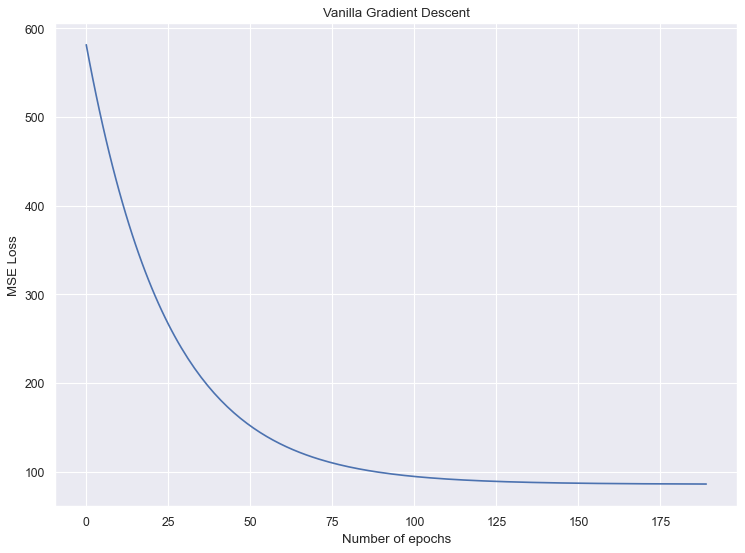

In [176]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd)
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Vanilla Gradient Descent")
plt.show()

## 4)- Stochastic Gradient Descent (SGD)

**Stochastic Gradient Descent (SGD)** will perform the gradient computing for every sample in the dataset. Therefore, one update of the weights is performed for every training sample, which makes it more efficient than VGD when having huge datasets, since it doesn't re-compute gradients for similar examples.

$$
\boxed{\forall k \in\{1, \ldots, N\}:  W^{(i+1)} = W^{(i)}-\alpha \nabla L_{W}\left(W^{(i)}, X^{(k)}, Y^{(k)}\right)}
$$

In [181]:
# Define the basic parameters for the gradient descent algorithms

n_epochs = 190
alpha = 0.01

In [182]:
def stochastic_gradient_descent(X, Y, F, alpha, n_epochs):
    W = np.zeros((F+1, 1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N):
            grad = 2/N * np.matmul((np.matmul(X[i:i+1,:], W) - Y[i:i+1,:]).T, X[i:i+1,:])
            W = W - alpha*grad.T
            err = norm(np.matmul(X[i:i+1,:],W) - Y[i:i+1,:])**2
            sum_errors += err
            
        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
 
    return W, loss

start = time.time()
W_sgd, loss_sgd = stochastic_gradient_descent(x_train, y_train, F, alpha, n_epochs)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_sgd) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 591.4063668418739 

Epoch: 1/190 | Loss: 571.5962217392233 

Epoch: 2/190 | Loss: 552.5940475302873 

Epoch: 3/190 | Loss: 534.2373516607719 

Epoch: 4/190 | Loss: 516.8036701667465 

Epoch: 5/190 | Loss: 499.83208123656806 

Epoch: 6/190 | Loss: 483.72014709210936 

Epoch: 7/190 | Loss: 468.05881777781246 

Epoch: 8/190 | Loss: 453.1391324438175 

Epoch: 9/190 | Loss: 438.6939187716973 

Epoch: 10/190 | Loss: 424.9633548024985 

Epoch: 11/190 | Loss: 411.6196555645875 

Epoch: 12/190 | Loss: 399.0686513768868 

Epoch: 13/190 | Loss: 386.5392606047777 

Epoch: 14/190 | Loss: 374.8659388705967 

Epoch: 15/190 | Loss: 363.696517875922 

Epoch: 16/190 | Loss: 352.48088499011584 

Epoch: 17/190 | Loss: 342.37576879125123 

Epoch: 18/190 | Loss: 332.10783605369915 

Epoch: 19/190 | Loss: 322.43497464097607 

Epoch: 20/190 | Loss: 313.54323732377725 

Epoch: 21/190 | Loss: 304.3901967345354 

Epoch: 22/190 | Loss: 295.88921692808856 

Epoch: 23/190 | Loss: 287.6455946145

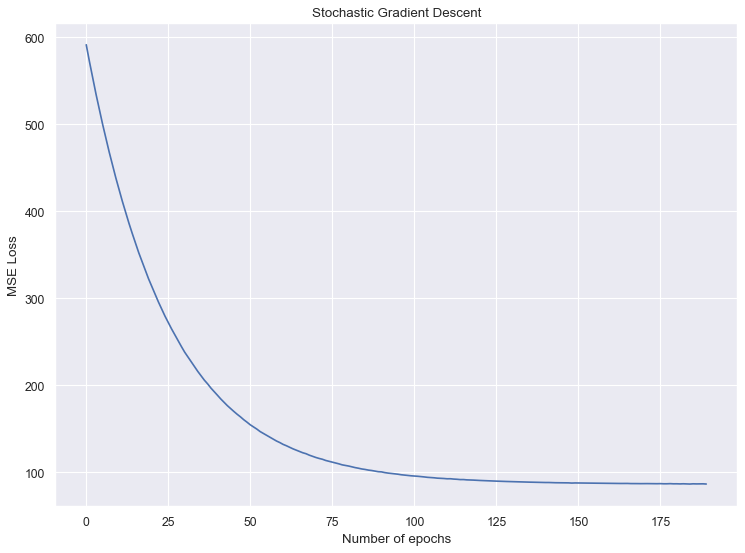

In [183]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_sgd)
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Stochastic Gradient Descent")
plt.show()

## 5)- Mini-batch Gradient Descent (MBGD)

**Mini-batch Gradient Descent (MBGD)** will perform the gradient computing for a mini-batch **mb** of data, instead of the whole dataset or just unique samples, making it faster compared to the previous VGD and SGD versions:

$$
\boxed{W^{(i+1)} = W^{(i)}-\alpha \nabla L_{W}\left(W^{(i)}, X^{(i:i+mb)}, Y^{(i:i+mb)}\right)}
$$

In [179]:
# Define the basic parameters for the MBGD

n_epochs = 190
alpha = 0.01
mb = 4

In [184]:
def minibatch_gradient_descent(X, Y, F, alpha, n_epochs, mb):
    W = np.zeros((F+1, 1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            W = W - alpha*grad.T
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
 
    return W, loss

start = time.time()
W_mbgd, loss_mbgd = minibatch_gradient_descent(x_train, y_train, F, alpha, n_epochs, mb)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_mbgd) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 559.3350349159127 

Epoch: 1/190 | Loss: 489.78668055949805 

Epoch: 2/190 | Loss: 430.4165937152186 

Epoch: 3/190 | Loss: 379.73245154873285 

Epoch: 4/190 | Loss: 336.7254150695789 

Epoch: 5/190 | Loss: 299.76497370681744 

Epoch: 6/190 | Loss: 268.57085417202677 

Epoch: 7/190 | Loss: 241.74087713988467 

Epoch: 8/190 | Loss: 218.6205173697042 

Epoch: 9/190 | Loss: 199.2891721048274 

Epoch: 10/190 | Loss: 182.6855989664982 

Epoch: 11/190 | Loss: 168.230413659409 

Epoch: 12/190 | Loss: 156.28460720913438 

Epoch: 13/190 | Loss: 146.19381164129115 

Epoch: 14/190 | Loss: 137.0002885123468 

Epoch: 15/190 | Loss: 129.75910214615854 

Epoch: 16/190 | Loss: 123.53690292899374 

Epoch: 17/190 | Loss: 117.76210821718644 

Epoch: 18/190 | Loss: 113.25949955542107 

Epoch: 19/190 | Loss: 109.16225628612136 

Epoch: 20/190 | Loss: 105.47724483078139 

Epoch: 21/190 | Loss: 102.91337498021174 

Epoch: 22/190 | Loss: 100.26553817430592 

Epoch: 23/190 | Loss: 98.77920

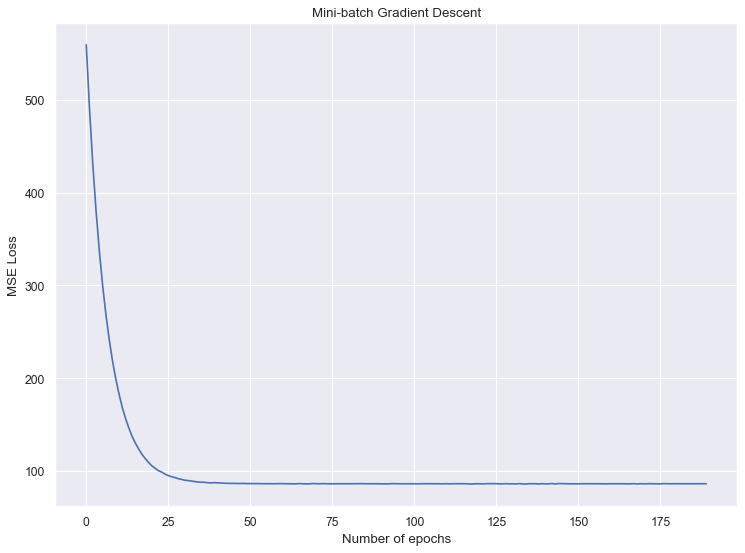

In [185]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_mbgd)
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Mini-batch Gradient Descent")
plt.show()

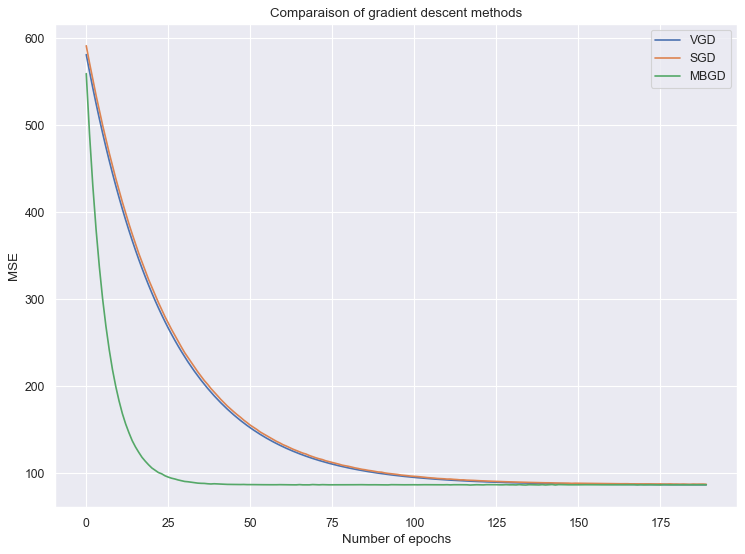

In [186]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

Here, we can see that **Mini-Batch Gradient Descent** is the fastest of the three algorithms, while **SGD** is the slowest. Normally, SGD is faster than VGD when dealing with huge datasets, but since our dataset is small we see that VGD and SGD are close in terms of speed convergence.

## 6)- Momentum with SGD algorithm

The classic **SGD** algorithm has trouble navigating through ravines (areas where the surface curves much more steeply in one dimension than in another), which are common around local optima. In these scenarios, SGD
oscillates across the slopes of the ravine while only making hesitant progress along the bottom
towards the local optimum.

To address this problem, we introduce a new term called **the momentum** $ \beta $, and **the velocity vector** $ V $ that we are adding to the gradient vector, in order to make an update on the weights. The intuition behing momentum with SGD is like a man walking down a hill. He follows the steepest path downwards, his progress is slow, but steady. Momentum is a heavy ball rolling down the same hill. The added momentum term acts both as a smoother and an accelerator, dampening oscillations and causing us to barrel through narrow valleys, small humps and local minima, which SGD fails to do.

$$
\boxed{\begin{array}{l}
V^{(i+1)} = \beta V^{(i)}+\alpha \nabla_{W} L\left(W^{(i)}\right) \\
W^{(i+1)} = W^{(i)} - V^{(i+1)}
\end{array}}
$$

In [195]:
# Define the basic parameters for Momentum

n_epochs = 190
alpha = 0.01
beta = 0.9
mb = 4

In [196]:
def momentum(X, Y, F, alpha, n_epochs, beta, mb):
    W = np.zeros((F+1, 1))
    V = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            V = beta * V + alpha * grad
            W = W - V.T
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_mom, loss_mom = momentum(x_train, y_train, F, alpha, n_epochs, beta, mb)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_mom) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 346.91640113134775 

Epoch: 1/190 | Loss: 137.79468590413518 

Epoch: 2/190 | Loss: 96.5200761292775 

Epoch: 3/190 | Loss: 88.17405359483973 

Epoch: 4/190 | Loss: 86.11265875547501 

Epoch: 5/190 | Loss: 87.01251638342086 

Epoch: 6/190 | Loss: 86.0885466113964 

Epoch: 7/190 | Loss: 86.3170508177057 

Epoch: 8/190 | Loss: 86.50571502989185 

Epoch: 9/190 | Loss: 86.10628472019255 

Epoch: 10/190 | Loss: 86.71880455467252 

Epoch: 11/190 | Loss: 86.36324547702161 

Epoch: 12/190 | Loss: 86.51198676230617 

Epoch: 13/190 | Loss: 86.38458018868177 

Epoch: 14/190 | Loss: 86.40615149142064 

Epoch: 15/190 | Loss: 86.18879255642717 

Epoch: 16/190 | Loss: 85.81784505520822 

Epoch: 17/190 | Loss: 86.40314050179134 

Epoch: 18/190 | Loss: 86.29596797928949 

Epoch: 19/190 | Loss: 85.99201216579564 

Epoch: 20/190 | Loss: 86.45036827118186 

Epoch: 21/190 | Loss: 86.3685831488923 

Epoch: 22/190 | Loss: 86.37181903014203 

Epoch: 23/190 | Loss: 86.45388899403925 

Epoc

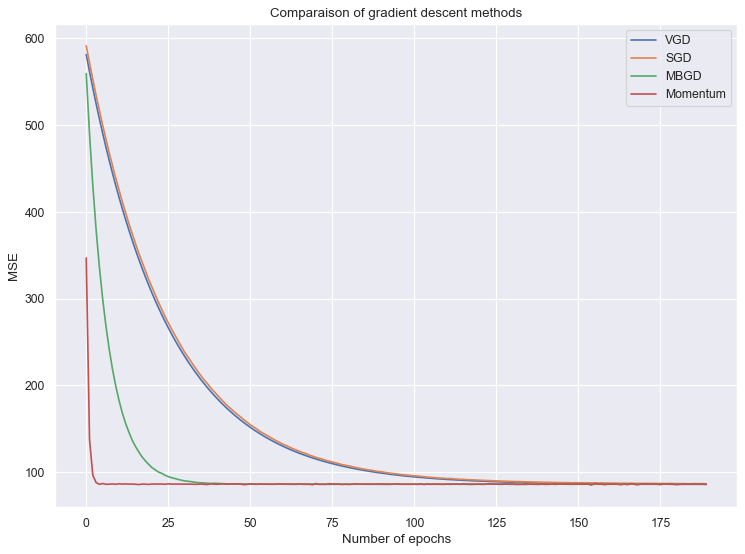

In [197]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 6)- Nesterov Accelerated Gradient (NAG)

**Momentum** algorithm is just like a ball following blindly the slope, since it doesn't know when to slow down. If we make this ball more intelligent by giving it some information about when to slow down, this will give us **The Nesterov Accelerated Gradient (NAG)**.

This algorithm will apply the same steps as the Momentum, however it will apply the gradient to the next approximate position of the weights, instead of the actual position like it was the case in Momentum.

$$
\boxed{\begin{array}{l}
V^{(i+1)} = \beta V^{(i)}+\alpha \nabla_{W} L\left(W^{(i)} - \beta V^{(i)}\right) \\
W^{(i+1)} = W^{(i)} - V^{(i+1)}
\end{array}}
$$

In [201]:
# Define the basic parameters for Momentum

n_epochs = 190
alpha = 0.01
beta = 0.8
mb = 4

In [202]:
def NAG(X, Y, F, alpha, n_epochs, beta, mb):
    W = np.zeros((F+1, 1))
    V = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            W_next = W - beta * V.T
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W_next) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            V = beta * V + alpha * grad
            W = W - V.T
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_nag, loss_nag = NAG(x_train, y_train, F, alpha, n_epochs, beta, mb)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_nag) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 440.7312625632076 

Epoch: 1/190 | Loss: 245.59152304277308 

Epoch: 2/190 | Loss: 157.7908460401098 

Epoch: 3/190 | Loss: 118.42206277536857 

Epoch: 4/190 | Loss: 100.9019337352858 

Epoch: 5/190 | Loss: 92.55248137667364 

Epoch: 6/190 | Loss: 89.34995072596809 

Epoch: 7/190 | Loss: 87.56585961927777 

Epoch: 8/190 | Loss: 86.81651694129516 

Epoch: 9/190 | Loss: 86.46710659921341 

Epoch: 10/190 | Loss: 86.1574947548639 

Epoch: 11/190 | Loss: 86.28883013676491 

Epoch: 12/190 | Loss: 85.93451978171068 

Epoch: 13/190 | Loss: 86.54516654782427 

Epoch: 14/190 | Loss: 86.23867205071487 

Epoch: 15/190 | Loss: 86.30561019644433 

Epoch: 16/190 | Loss: 85.95796529382568 

Epoch: 17/190 | Loss: 86.22559701181683 

Epoch: 18/190 | Loss: 86.04767186898813 

Epoch: 19/190 | Loss: 86.38185651722709 

Epoch: 20/190 | Loss: 86.31898574671203 

Epoch: 21/190 | Loss: 86.03838476329221 

Epoch: 22/190 | Loss: 86.150297504954 

Epoch: 23/190 | Loss: 86.42222079081749 

Epo

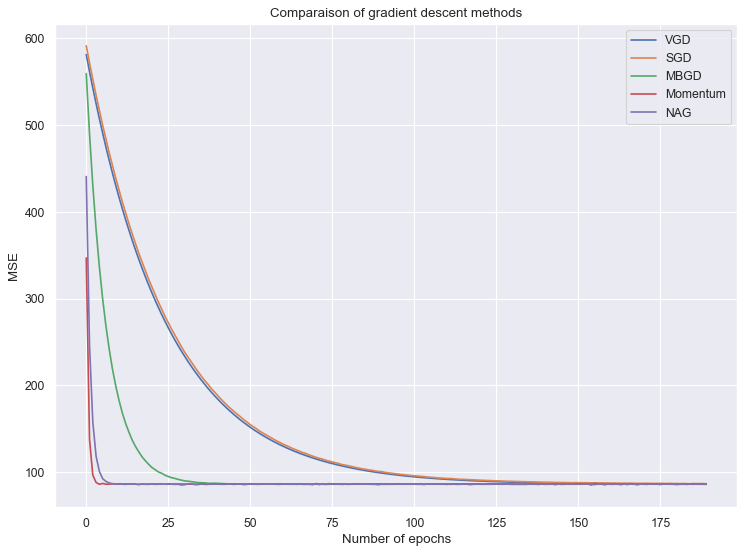

In [203]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 7)- Adagrad (Adaptive gradient)

**Adagrad** will adapt the learning rate $ \alpha $ all along the gradient descent process, by dividing each weight on a quantity based on the sum of the previous squared gradient up to time $ t $. Therefore, the update will be large for infrequent data samples, and small for frequent ones, which makes it a perfectly suited algorithm for sparse data.

$$
\boxed{W^{(i+1)}=W^{(i)}-\frac{\alpha}{\sqrt{G_{i}+\varepsilon}} \odot \nabla_{W} L\left(W^{(i)}\right)}
$$

$ \underline{where:} $

- $ G_{i} $ is diagonal matrix of size $ \mathbb{R}^{F+1,F+1} $ containing in each diagonal the sum of the squared gradient of parameter $ w_{i} $, up until time t.

- $ \varepsilon $ is a parameter that we add to avoid division by zero, usually fixed to $ 10^{-8} $.

- $ \odot $ is the element-wise product of matrices.

In [206]:
# Define the basic parameters for Adagrad

n_epochs = 190
epsilon = 1e-8
alpha = 0.1
mb = 4

In [207]:
def adagrad(X, Y, F, alpha, n_epochs, mb, epsilon):
    W = np.zeros((F+1, 1))
    Gi = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            Gi += grad ** 2
            new_alpha = alpha / np.sqrt(Gi + epsilon)
            W = W - np.multiply(new_alpha.T, grad.T)
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_ada, loss_ada = adagrad(x_train, y_train, F, alpha, n_epochs, mb, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_ada) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 489.9859430630626 

Epoch: 1/190 | Loss: 407.59125432310833 

Epoch: 2/190 | Loss: 361.2212084106423 

Epoch: 3/190 | Loss: 327.8900589899389 

Epoch: 4/190 | Loss: 300.7186671726255 

Epoch: 5/190 | Loss: 278.39877728925075 

Epoch: 6/190 | Loss: 259.5159235364086 

Epoch: 7/190 | Loss: 243.6751389855561 

Epoch: 8/190 | Loss: 230.6344056875209 

Epoch: 9/190 | Loss: 218.71792025738048 

Epoch: 10/190 | Loss: 207.33187772892245 

Epoch: 11/190 | Loss: 197.88155092416847 

Epoch: 12/190 | Loss: 189.0036043341228 

Epoch: 13/190 | Loss: 180.77184091868628 

Epoch: 14/190 | Loss: 173.7815231301134 

Epoch: 15/190 | Loss: 167.76156768855006 

Epoch: 16/190 | Loss: 161.44491825334268 

Epoch: 17/190 | Loss: 156.04117452417572 

Epoch: 18/190 | Loss: 151.18257079517755 

Epoch: 19/190 | Loss: 146.06394900962638 

Epoch: 20/190 | Loss: 142.14839992331298 

Epoch: 21/190 | Loss: 139.4141668845934 

Epoch: 22/190 | Loss: 135.38411979960497 

Epoch: 23/190 | Loss: 132.16295

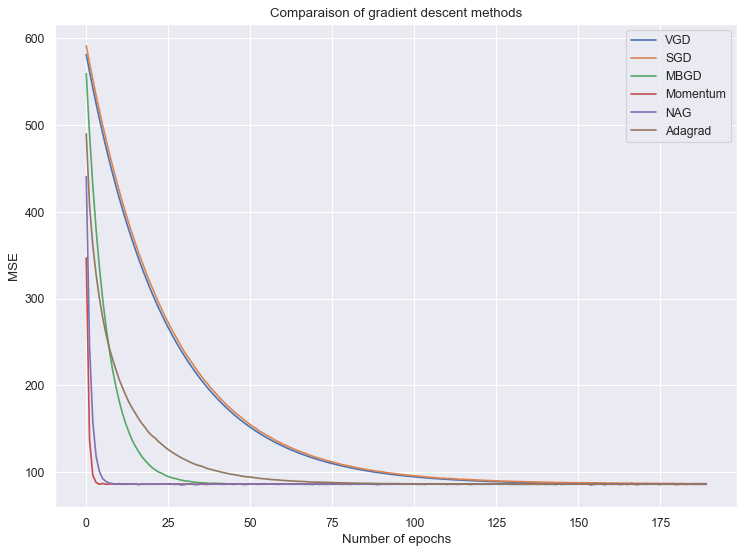

In [208]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 8)- Adadelta

**Adadelta** is an improvement of Adagrad, that seeks to change the way the learning rate is decreasing. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w.

$$
\boxed{W^{(i+1)}=W^{(i)}+\Delta W^{(i)} \\ \\
\Delta W^{(i)}=-\frac{R M S[\Delta W]_{i-1}}{\operatorname{RMS}[\nabla_{W} L]_{i}} \nabla_{W} L\left(W^{(i)}\right)}
$$

$ \underline{where:} $


- $ \operatorname{RMS}[X]_{i}=\sqrt{\mathbb{E}\left[X^{2}\right]_{i}+\varepsilon} $ is the root mean square error criterion of the quantity X up to time i, and $ \epsilon $ is a parameter we add to avoid division by zero.


- $\mathbb{E}\left[X^{2}\right]_{i}=\gamma \mathbb{E}\left[X^{2}\right]_{i-1}+(1-\gamma) X_{i}^{2}$ is the exponential decaying average of all past squared quantities $ X $ up to time i, and $ \gamma $ is the decay.


- $ X $ can either be the parameter updates $ \Delta W $ or the gradient $ \nabla_{W} L $ .





In [226]:
# Define the basic parameters for Adadelta

n_epochs = 190
epsilon = 1e-8
alpha = 0.01
gamma = 0.8
mb = 4

In [227]:
def adadelta(X, Y, F, alpha, n_epochs, gamma, mb, epsilon):
    W = np.zeros((F+1, 1))
    E_g = np.zeros((1, F+1))
    E_d = np.zeros((1, F+1))
    RMS_delta = np.zeros((F+1, 1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            E_g = gamma * E_g + (1 - gamma) * grad ** 2
            RMS_grad = np.sqrt(E_g + epsilon)
            W = W - np.multiply(np.divide(RMS_delta, RMS_grad.T), grad.T)
            
            delta_w = np.multiply(-alpha / RMS_grad, grad)
            E_d = gamma * E_d + (1 - gamma) * delta_w ** 2
            RMS_delta = np.sqrt(E_d.T + epsilon)
            
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_delta, loss_delta = adadelta(x_train, y_train, F, alpha, n_epochs, gamma, mb, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_delta) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 502.57017638381785 

Epoch: 1/190 | Loss: 344.2833221308343 

Epoch: 2/190 | Loss: 225.22089688693876 

Epoch: 3/190 | Loss: 147.35565789568156 

Epoch: 4/190 | Loss: 104.86030136273355 

Epoch: 5/190 | Loss: 90.93967189843367 

Epoch: 6/190 | Loss: 86.98286200371142 

Epoch: 7/190 | Loss: 86.10796599359762 

Epoch: 8/190 | Loss: 86.10629009341295 

Epoch: 9/190 | Loss: 85.72999131958107 

Epoch: 10/190 | Loss: 85.97781524166847 

Epoch: 11/190 | Loss: 86.11225547844916 

Epoch: 12/190 | Loss: 85.92910947075141 

Epoch: 13/190 | Loss: 86.22233097697205 

Epoch: 14/190 | Loss: 85.93112423702458 

Epoch: 15/190 | Loss: 86.03227761959701 

Epoch: 16/190 | Loss: 85.98038814316436 

Epoch: 17/190 | Loss: 85.9737454591432 

Epoch: 18/190 | Loss: 85.88570808517112 

Epoch: 19/190 | Loss: 85.05796044901396 

Epoch: 20/190 | Loss: 86.18456502592906 

Epoch: 21/190 | Loss: 85.53037713337851 

Epoch: 22/190 | Loss: 86.2148519214132 

Epoch: 23/190 | Loss: 85.97763803869832 



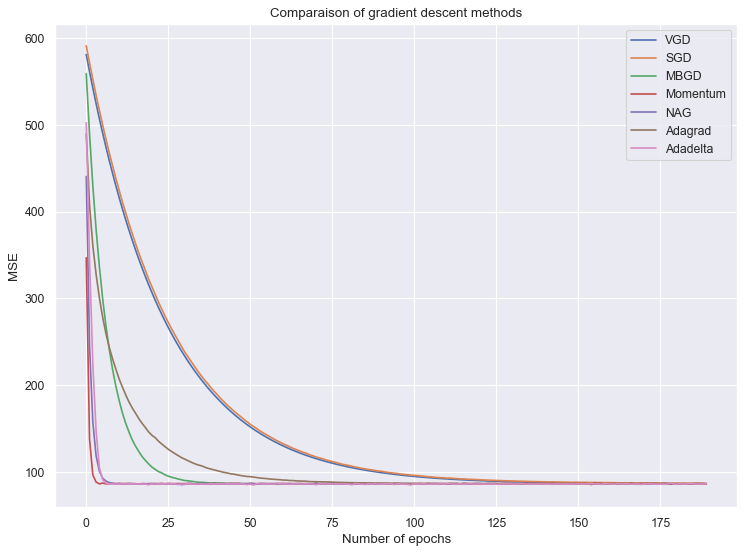

In [228]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')
plt.plot(loss_delta, label = 'Adadelta')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 9)- RMSprop

**RMSprop** and **Adadelta** are two adaptative learning rate methods that were proposed in order to tackle the problem of Adagrad’s radically diminishing learning rates. **RMSprop** will keep the first learning rate update of Adadelta, by dividing the learning rate by an exponentially decaying average of past squared gradients.

$$
\boxed{
W^{(i+1)}=W^{(i)}-\frac{\alpha}{\sqrt{\mathbb{E}\left[\nabla_{W} L^{2}\right]_{i}+\varepsilon}} \nabla_{W} L\left(W^{(i)}\right)}
$$

$$
\boxed{
\mathbb{E}\left[\nabla_{W} L^{2}\right]_{i}=0.9 \mathbb{E}\left[\nabla_{W} L^{2}\right]_{i-1}+0,1 \nabla_{W} L\left(W^{(i)}\right)^{2}}
$$


In [230]:
# Define the basic parameters for RMSprop

n_epochs = 190
epsilon = 1e-8
alpha = 0.01
mb = 4

In [231]:
def RMSprop(X, Y, F, alpha, n_epochs, mb, epsilon):
    W = np.zeros((F+1, 1))
    E_g = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            E_g = 0.9 * E_g + 0.1 * grad ** 2
            new_alpha = alpha / np.sqrt(E_g + epsilon)
            W = W - np.multiply(new_alpha.T, grad.T)
            
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_rms, loss_rms = RMSprop(x_train, y_train, F, alpha, n_epochs, mb, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_rms) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 500.20072191598234 

Epoch: 1/190 | Loss: 342.3948873241719 

Epoch: 2/190 | Loss: 223.20227221382345 

Epoch: 3/190 | Loss: 143.93445448594065 

Epoch: 4/190 | Loss: 104.07167912039142 

Epoch: 5/190 | Loss: 89.57906523957656 

Epoch: 6/190 | Loss: 86.11733166103957 

Epoch: 7/190 | Loss: 86.34259472390063 

Epoch: 8/190 | Loss: 86.0042434982281 

Epoch: 9/190 | Loss: 85.82823192113977 

Epoch: 10/190 | Loss: 85.92692692315416 

Epoch: 11/190 | Loss: 85.8271963147282 

Epoch: 12/190 | Loss: 85.90614714089006 

Epoch: 13/190 | Loss: 85.9239217066366 

Epoch: 14/190 | Loss: 85.89875124981 

Epoch: 15/190 | Loss: 85.9351793118734 

Epoch: 16/190 | Loss: 85.70052426773113 

Epoch: 17/190 | Loss: 86.00434156467776 

Epoch: 18/190 | Loss: 85.86698954799853 

Epoch: 19/190 | Loss: 86.03144468467407 

Epoch: 20/190 | Loss: 85.94892499109972 

Epoch: 21/190 | Loss: 85.90646854977614 

Epoch: 22/190 | Loss: 84.4167076962093 

Epoch: 23/190 | Loss: 86.31134796599584 

Epoch:

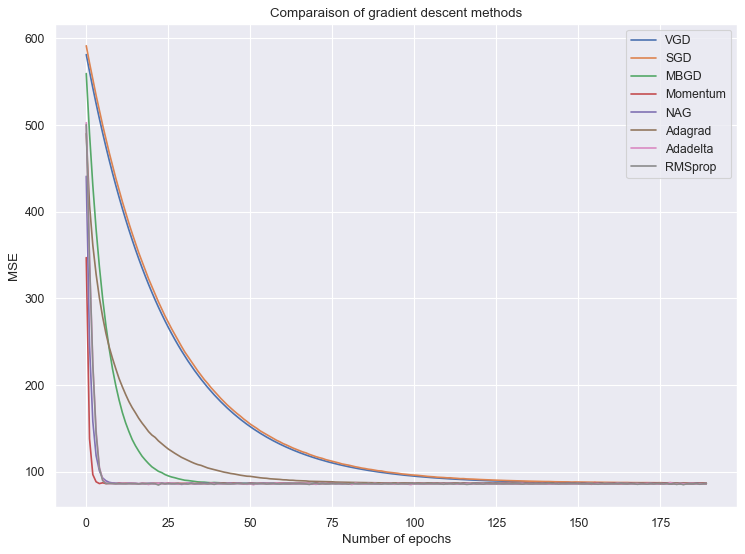

In [232]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')
plt.plot(loss_delta, label = 'Adadelta')
plt.plot(loss_rms, label = 'RMSprop')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 10)- Adam (Adaptive moment estimation)

**Adam** is also an adaptative learning rate algorithm just like the previous ones, it starts by computing the exponentially decaying average of past gradients (first moment estimation of gradient), and the exponentially decaying average of past squared gradients (second moment estimation of gradient). After that, we make a correction of the previously computed moments since they are biased towards zero, and we use the resulting corrections for updating the weights.

$$
\boxed{
m_{i}=\beta_{1} m_{i-1}+\left(1-\beta_{1}\right) \nabla_{W} L\left(W^{(i)}\right) \\
v_{i}=\beta_{2} v_{i-1}+\left(1-\beta_{2}\right) \nabla_{W} L\left(W^{(i)}\right)^{2}}
$$

$$
\boxed{
\hat{m}_{i}=\frac{m_{i}}{1-\beta_{1}} \\
\hat{v}_{i}=\frac{v_{i}}{1-\beta_{2}}}
$$

$$
\boxed{
W^{(i+1)} = W^{(i)}-\frac{\alpha}{\sqrt{\hat{v}_{i}}+\varepsilon} \hat{m}_{i}}
$$


$ \underline{where:} $

- $ m_{i} $ and $ v_{i} $ are respectively the first and the second moment estimation of the gradient.
- $ \hat{m_{i}} $ and $ \hat{v_{i}} $ are respectively the bias-corrected versions of first and second moments of gradient.




In [233]:
# Define the basic parameters for Adam

n_epochs = 190
epsilon = 1e-8
alpha = 0.01
beta1 = 0.9
beta2 = 0.999
mb = 4

In [234]:
def adam(X, Y, F, alpha, n_epochs, mb, beta1, beta2, epsilon):
    W = np.zeros((F+1, 1))
    m = np.zeros((1, F+1))
    v = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            # Compute the gradient, and its first and second moment estimation
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad ** 2
            
            # Compute the bias-corrected versions of the moment
            m_hat = m / (1 - beta1)
            v_hat = v / (1 - beta2)
            new_alpha = alpha / (np.sqrt(v_hat) + epsilon)
            
            # Update the weights
            W = W - np.multiply(new_alpha.T, m_hat.T)
            
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_adam, loss_adam = adam(x_train, y_train, F, alpha, n_epochs, mb, beta1, beta2, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_adam) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 501.73259338239217 

Epoch: 1/190 | Loss: 409.6618578075682 

Epoch: 2/190 | Loss: 352.8434847488599 

Epoch: 3/190 | Loss: 307.9283301042971 

Epoch: 4/190 | Loss: 270.9629546516235 

Epoch: 5/190 | Loss: 239.1014880558877 

Epoch: 6/190 | Loss: 211.1583953472085 

Epoch: 7/190 | Loss: 187.6669737704789 

Epoch: 8/190 | Loss: 167.21650608565784 

Epoch: 9/190 | Loss: 149.8018442766782 

Epoch: 10/190 | Loss: 135.3382846800439 

Epoch: 11/190 | Loss: 122.96593814764441 

Epoch: 12/190 | Loss: 112.81929500114096 

Epoch: 13/190 | Loss: 105.12099753618176 

Epoch: 14/190 | Loss: 99.43039610181728 

Epoch: 15/190 | Loss: 94.93191896676387 

Epoch: 16/190 | Loss: 91.70065297282821 

Epoch: 17/190 | Loss: 89.58997826036791 

Epoch: 18/190 | Loss: 88.3838660174744 

Epoch: 19/190 | Loss: 87.28486591119282 

Epoch: 20/190 | Loss: 86.87574058403646 

Epoch: 21/190 | Loss: 86.41994885816999 

Epoch: 22/190 | Loss: 86.49604891551743 

Epoch: 23/190 | Loss: 86.50308864118007 

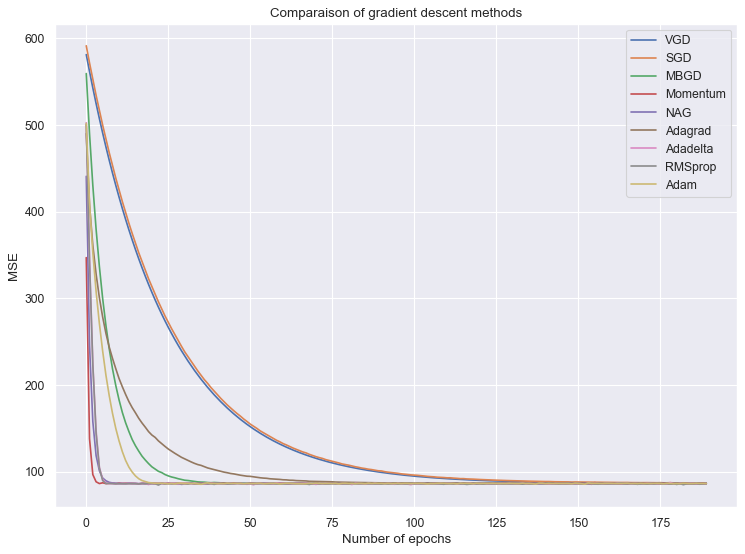

In [237]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')
plt.plot(loss_delta, label = 'Adadelta')
plt.plot(loss_rms, label = 'RMSprop')
plt.plot(loss_adam, label = 'Adam')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 11)- Adamax

**Adamax** inherits from **Adam** algorithm, and instead of computing the second moment of the gradient based on the $ \ell_{2} $ norm , we compute it based on the $ \ell_{\infty} $ norm, since experiences show that we get more stable results by using this norm.


$$
\boxed{
m_{i}=\beta_{1} m_{i-1}+\left(1-\beta_{1}\right) \nabla_{W} L\left(W^{(i)}\right) \\
v_{i}=\beta_{2} v_{i-1}+\left(1-\beta_{2}\right) \nabla_{W} L\left(W^{(i)}\right)^{2}}
$$

$$
\boxed{
\hat{m}_{i}=\frac{m_{i}}{1-\beta_{1}}}
$$

$$
\boxed{
u_{i}=\beta_{2}^{\infty} v_{i-1}+\left(1-\beta_{2}^{\infty}\right)\left|\nabla_{W}L\left(W^{(i)}\right)\right|^{\infty} = \max \left(\beta_{2} v_{i-1}, \quad\left|\nabla_{W} L\left(W^{(i)}\right)\right|\right)}
$$

$$
\boxed{W^{(i+1)}=W^{(i)}-\frac{\alpha}{u_{i}} \hat{m}_{i}}
$$




In [249]:
# Define the basic parameters for Adamax

n_epochs = 190
epsilon = 1e-8
alpha = 0.001
beta1 = 0.9
beta2 = 0.999
mb = 4

In [250]:
def adamax(X, Y, F, alpha, n_epochs, mb, beta1, beta2, epsilon):
    W = np.zeros((F+1, 1))
    m = np.zeros((1, F+1))
    v = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            # Compute the gradient, and its first moment estimation
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            m = beta1 * m + (1 - beta1) * grad
            
            # Compute the bias-corrected version of the first moment
            m_hat = m / (1 - beta1)
            u = np.maximum(beta2 * v, np.abs(grad))
            new_alpha = alpha / u
            
            # Update the vector v and the weights
            v = beta2 * v + (1 - beta2) * grad ** 2
            W = W - np.multiply(new_alpha.T, m_hat.T)
            
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_adamax, loss_adamax = adamax(x_train, y_train, F, alpha, n_epochs, mb, beta1, beta2, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_adamax) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 503.1598791189456 

Epoch: 1/190 | Loss: 332.14306023272104 

Epoch: 2/190 | Loss: 199.42983398205965 

Epoch: 3/190 | Loss: 114.3953472843446 

Epoch: 4/190 | Loss: 89.457593192878 

Epoch: 5/190 | Loss: 87.42558664640215 

Epoch: 6/190 | Loss: 87.28034086930292 

Epoch: 7/190 | Loss: 86.71166452601611 

Epoch: 8/190 | Loss: 86.83747124707475 

Epoch: 9/190 | Loss: 87.14718877857673 

Epoch: 10/190 | Loss: 87.4256492566503 

Epoch: 11/190 | Loss: 87.01977632126324 

Epoch: 12/190 | Loss: 87.20776532194944 

Epoch: 13/190 | Loss: 87.05378118930221 

Epoch: 14/190 | Loss: 86.88129785031295 

Epoch: 15/190 | Loss: 87.18723444782093 

Epoch: 16/190 | Loss: 86.83935249927181 

Epoch: 17/190 | Loss: 87.52728456574715 

Epoch: 18/190 | Loss: 87.32762428616614 

Epoch: 19/190 | Loss: 87.33303249084736 

Epoch: 20/190 | Loss: 87.35037724949655 

Epoch: 21/190 | Loss: 87.31301038480791 

Epoch: 22/190 | Loss: 86.96151539714667 

Epoch: 23/190 | Loss: 86.9534556932357 

Epoc

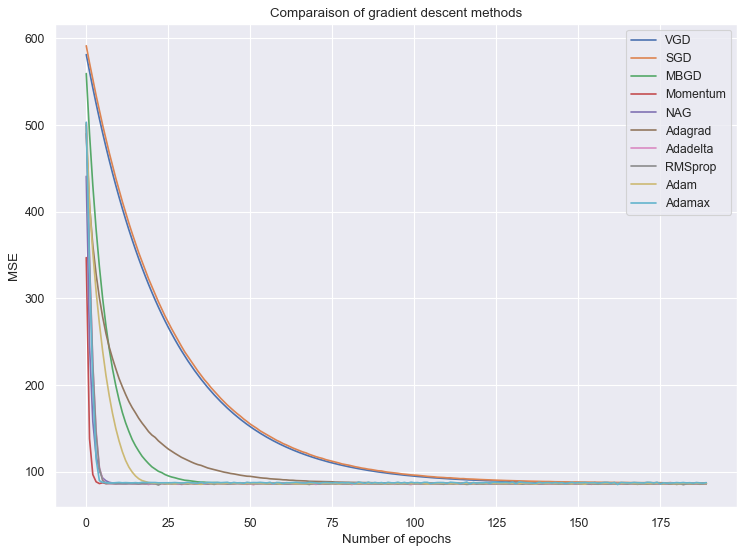

In [251]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')
plt.plot(loss_delta, label = 'Adadelta')
plt.plot(loss_rms, label = 'RMSprop')
plt.plot(loss_adam, label = 'Adam')
plt.plot(loss_adamax, label = 'Adamax')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 12)- Nadam (Nesterov-accelerated Adaptive Moment Estimation)

**Nadam** is a combination of **Adam** and **NAG** algorithms. It gives the look-ahead property of NAG to momentum, and instead of updating the weights based on the bias-corrected momentum of the previous instant, we update it using the momentum the actual instant.


$$
\boxed{
W^{(i+1)}=W^{(i)}-\frac{\alpha}{\sqrt{\hat{v_{i}}}+\varepsilon}\left(\beta_{1} \hat{m}_{i}+\frac{\left(1-\beta_{1}\right) \nabla_{W} L\left(W^{(i)}\right)}{1-\beta_{1}^{t}}\right)}
$$



In [268]:
# Define the basic parameters for Nadam

n_epochs = 190
epsilon = 1e-8
alpha = 0.014
beta1 = 0.9
beta2 = 0.999
mb = 4

In [269]:
def nadam(X, Y, F, alpha, n_epochs, mb, beta1, beta2, epsilon):
    W = np.zeros((F+1, 1))
    m = np.zeros((1, F+1))
    v = np.zeros((1, F+1))
    N = X.shape[0]
    loss = []
    for _ in range(n_epochs):
        np.random.shuffle(X)
        sum_errors = 0
        for i in range(N-mb+1):
            # Compute the gradient, and its first and second moment estimation
            grad = 2/N * np.matmul((np.matmul(X[i:i+mb,:], W) - Y[i:i+mb,:]).T, X[i:i+mb,:])
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad ** 2
            
            # Compute the bias-corrected version of the first and second moment
            m_hat = m / (1 - beta1)
            v_hat = v / (1 - beta2)
            new_alpha = alpha / (np.sqrt(v_hat) + epsilon)
            
            # Update the weights
            W = W - np.multiply(new_alpha.T, beta1 * m_hat.T + (1 - beta1) * grad.T / (1 - beta1))
            
            err = 1/mb * norm(np.matmul(X[i:i+mb,:],W) - Y[i:i+mb,:])**2
            sum_errors += err

        loss.append(1/N * sum_errors)
        print("Epoch: {}/{} | Loss: {} \n".format(_, n_epochs, loss[-1]))
        
    return W, loss

start = time.time()
W_nadam, loss_nadam = nadam(x_train, y_train, F, alpha, n_epochs, mb, beta1, beta2, epsilon)
duration = time.time() - start
print("The training is over in {}s".format(round(duration, 2)))

# Test on new data samples with RMSE loss
test_loss = np.sqrt(1/n_test * norm(np.matmul(x_test, W_nadam) - y_test)**2)
print("The test RMSE loss is: {}".format(test_loss))

Epoch: 0/190 | Loss: 465.98612343702115 

Epoch: 1/190 | Loss: 349.7123749002113 

Epoch: 2/190 | Loss: 282.62826797974674 

Epoch: 3/190 | Loss: 233.9924234218045 

Epoch: 4/190 | Loss: 196.3848072293595 

Epoch: 5/190 | Loss: 167.0957665967853 

Epoch: 6/190 | Loss: 143.93168291664284 

Epoch: 7/190 | Loss: 126.07204309075425 

Epoch: 8/190 | Loss: 112.67688775841647 

Epoch: 9/190 | Loss: 103.05681889135073 

Epoch: 10/190 | Loss: 96.01915653132039 

Epoch: 11/190 | Loss: 91.68497007513385 

Epoch: 12/190 | Loss: 88.93435646989356 

Epoch: 13/190 | Loss: 87.93416137032126 

Epoch: 14/190 | Loss: 87.30658426798466 

Epoch: 15/190 | Loss: 86.15343666604899 

Epoch: 16/190 | Loss: 86.32317752638671 

Epoch: 17/190 | Loss: 86.06604031516655 

Epoch: 18/190 | Loss: 86.50840697069104 

Epoch: 19/190 | Loss: 86.44447108101778 

Epoch: 20/190 | Loss: 86.00102977825608 

Epoch: 21/190 | Loss: 86.38433483125358 

Epoch: 22/190 | Loss: 85.85257128733542 

Epoch: 23/190 | Loss: 86.3401851652973

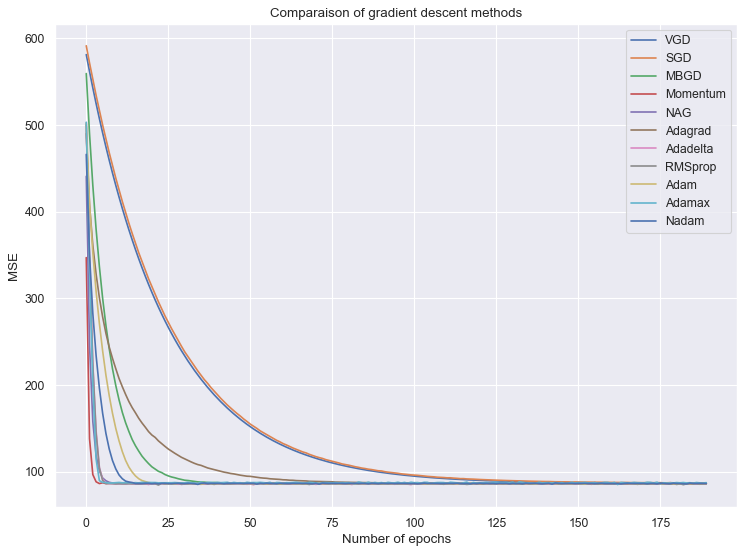

In [270]:
plt.figure(figsize=(11, 8), dpi=80)
plt.plot(loss_vgd, label = 'VGD')
plt.plot(loss_sgd, label = 'SGD')
plt.plot(loss_mbgd, label = 'MBGD')
plt.plot(loss_mom, label = 'Momentum')
plt.plot(loss_nag, label = 'NAG')
plt.plot(loss_ada, label = 'Adagrad')
plt.plot(loss_delta, label = 'Adadelta')
plt.plot(loss_rms, label = 'RMSprop')
plt.plot(loss_adam, label = 'Adam')
plt.plot(loss_adamax, label = 'Adamax')
plt.plot(loss_nadam, label = 'Nadam')

plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()